In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

print(os.getcwd())
sys.path.append(str(Path('../src').resolve()))

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm

from tqdm import tqdm

from implicits import SIREN, MFN, continuous_diff

In [4]:
# Load Data
path_to_csv0 = Path("../../data/clippeddata/clippedMarco0.txt")
path_to_csv1 = Path("../../data/clippeddata/clippedMarco1.txt")

data_t0 = pd.read_csv(path_to_csv0).to_numpy()[:,:3]
data_t0 = np.concatenate([data_t0, np.zeros((data_t0.shape[0],1))], axis=-1)
print('Data t0:', data_t0.shape)
data_t1 = pd.read_csv(path_to_csv1).to_numpy()[:,:3]
data_t1 = np.concatenate([data_t1, np.ones((data_t1.shape[0],1))], axis=-1)
print('Data t1:', data_t1.shape)

data = np.concatenate([data_t0, data_t1], axis=0)
col_names = ["x","y","z","t"]

print("min", np.min(data, axis=0))
print("mean", np.mean(data, axis=0))
print("max", np.max(data, axis=0))

Data t0: (24253, 4)
Data t1: (26658, 4)
min [  6.375 216.5   248.309   0.   ]
mean [ 36.41119797 238.84924672 261.26950427   0.52361965]
max [ 64.5   261.5   275.804   1.   ]


(512, 512)


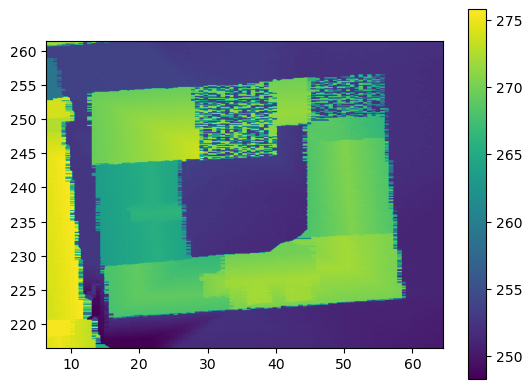

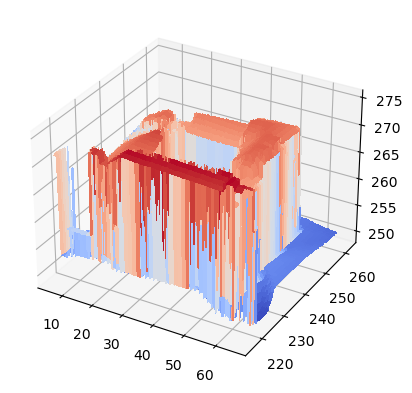

In [5]:
# interpolation
xmax = np.max(data[:,:2], axis=0)
xmin = np.min(data[:,:2], axis=0)

# sort data by first column (xcoord)
data_sorted = data.copy()
data_sorted[data_sorted[:, 0].argsort()]

n_points = 512
xy = np.stack(np.meshgrid(
    np.linspace(np.floor(xmin[0]), np.ceil(xmax[0]), n_points),
    np.linspace(np.floor(xmin[1]), np.ceil(xmax[1]), n_points),
    indexing='ij'
), axis=-1)

interp = interpolate.NearestNDInterpolator(data[:,:2], data[:,2])
z = interp(xy)
print(z.shape)


plt.imshow(z, extent=[xmin[0], xmax[0], xmin[1], xmax[1]])
plt.colorbar()
plt.show()

# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xy[...,0], xy[...,1], z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [6]:
def powerspec(data):
    print ("shape of data = ",data.shape)
    eps = 1e-50 # to void log(0)
    c  = np.sqrt(1.4);
    Ma = 0.1;
    U0 = Ma*c; 
    U = data/U0
    amplsU = np.abs(np.fft.fftn(U)/U.size)

    EK_U  = amplsU**2

    EK_U = np.fft.fftshift(EK_U)

    sign_sizex = np.shape(EK_U)[0]
    sign_sizey = np.shape(EK_U)[1]

    box_sidex = sign_sizex
    box_sidey = sign_sizey

    box_radius = int(np.ceil((np.sqrt((box_sidex)**2+(box_sidey)**2))/2.)+1)

    centerx = int(box_sidex/2)
    centery = int(box_sidey/2)

    print ("box sidex     =",box_sidex) 
    print ("box sidey     =",box_sidey) 
    print ("sphere radius =",box_radius )
    print ("centerbox     =",centerx)
    print ("centerboy     =",centery)

    EK_U_avsphr = np.zeros(box_radius,)+eps ## size of the radius

    for i in range(box_sidex):
        for j in range(box_sidey):
            wn =  int(np.round(np.sqrt((i-centerx)**2+(j-centery)**2)))
            EK_U_avsphr[wn] = EK_U_avsphr [wn] + EK_U [i,j]

    return EK_U_avsphr


(512, 512)
(512, 512)
shape of data =  (512, 512)
box sidex     = 512
box sidey     = 512
sphere radius = 364
centerbox     = 256
centerboy     = 256


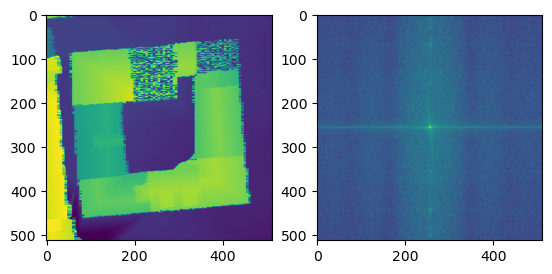

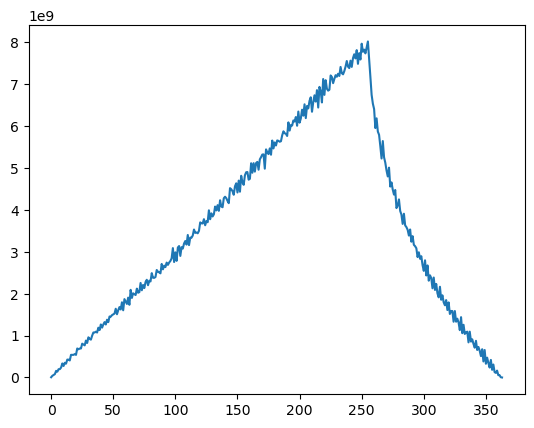

In [7]:
# spatial resolution of the data
nfft = 512
print(z.shape)
Z = np.fft.fft2(z, s=[nfft,nfft])
Z = np.fft.fftshift(Z)
print(Z.shape)

Ek = powerspec(Z)

plt.subplot(121)
plt.imshow(z)
plt.subplot(122)
plt.imshow(np.abs(Z), norm=LogNorm(vmin=5))
plt.show()

plt.plot(Ek)
plt.show()

## Graph Signal Processing

In [8]:
from scipy.spatial import Delaunay
import networkx as nx

In [49]:
print(data.shape)
pts = data[::8,:3]
print(pts.shape)
tess = Delaunay(pts, incremental=True)
simplices = tess.simplices
print(simplices.shape)

# post processing
# Separating small and large edges:
thresh = 3.0  # user defined threshold in meters
small_edges = set()
large_edges = set()
for tr in tess.vertices:
    for i in range(3):
        edge_idx0 = tr[i]
        edge_idx1 = tr[(i+1)%3]
        if (edge_idx1, edge_idx0) in small_edges:
            continue  # already visited this edge from other side
        if (edge_idx1, edge_idx0) in large_edges:
            continue
        p0 = pts[edge_idx0]
        p1 = pts[edge_idx1]
        if np.linalg.norm(p1 - p0) <  thresh:
            small_edges.add((edge_idx0, edge_idx1))
        else:
            large_edges.add((edge_idx0, edge_idx1))

simplices = small_edges

# Convert it in to graph for further processing
G = nx.Graph()
for path in simplices:
    nx.add_path(G, path)

# lap = nx.laplacian_matrix(G).toarray()

(50911, 4)
(6364, 3)
(39464, 4)


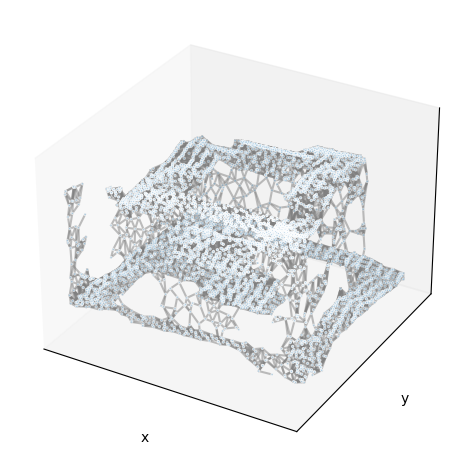

In [50]:
# Extract node and edge positions from the layout
node_xyz = np.array([pts[v] for v in sorted(G)])
edge_xyz = np.array([(pts[u], pts[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=2, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray", alpha=0.5)


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()


In [51]:
lap = nx.laplacian_matrix(G).toarray()
plt.imshow(lap)

In [59]:
import open3d as o3d
import 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [96]:
print(data.shape)
pts = data[::8,:3]
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

path_to_ply_data = str(Path("../../data/point_cloud.ply"))
# o3d.io.write_point_cloud(path_to_ply_data, pcd)

# Load saved point cloud and visualize it
# pcd = o3d.io.read_point_cloud(path_to_ply_data)

downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

radius =  3. # metres
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
dist, az, el = [1000, 0, 80]
campera_loc_car = np.array([
    dist*np.cos(np.deg2rad(el))*np.cos(np.deg2rad(az)),
    dist*np.cos(np.deg2rad(el))*np.sin(np.deg2rad(az)),
    dist*np.sin(np.deg2rad(el))
])
downpcd.orient_normals_towards_camera_location(
    camera_location=campera_loc_car)
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

(50911, 4)


In [94]:
# heuristics

## prune isolated points
radius = 1 # meter
nb_points = 1
cl, ind = downpcd.remove_radius_outlier(nb_points=nb_points, radius=radius)
inlier_cloud = downpcd.select_by_index(ind)
# outlier_cloud = downpcd.select_by_index(ind, invert=True)
o3d.visualization.draw_geometries([inlier_cloud], point_show_normal=True)

downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)


## prune points with horizontal norms
print("Print the normal vectors of the first 10 points")
print(np.asarray(downpcd.normals)[:10, :])

Print the normal vectors of the first 10 points
[[ 0.2251285  -0.20908673 -0.95163013]
 [ 0.12451828 -0.10410307 -0.98674097]
 [-0.         -0.         -1.        ]
 [-0.02259061  0.05128586 -0.99842848]
 [-0.         -0.         -1.        ]
 [-0.         -0.         -1.        ]
 [-0.         -0.         -1.        ]
 [-0.         -0.         -1.        ]
 [ 0.         -1.         -0.        ]
 [ 0.17212528 -0.37165086 -0.91227656]]


### Prune Vertical points

In [93]:
# prune vertical points
print(data.shape)
pts = data[::8,:3]
print(pts.shape)
tess = Delaunay(pts, incremental=True)
simplices = tess.simplices
print(simplices.shape)
print(tess.vertices.shape)
print(tess.equations.shape)
print(tess.equations)
# post processing
# # Separating small and large edges:
# thresh = 3.0  # user defined threshold in meters
# small_edges = set()
# large_edges = set()
# for v, tr in enumerate(tess.vertices):
#     for i in range(3):
#         edge_idx0 = tr[i]
#         edge_idx1 = tr[(i+1)%3]
#         if (edge_idx1, edge_idx0) in small_edges:
#             continue  # already visited this edge from other side
#         if (edge_idx1, edge_idx0) in large_edges:
#             continue
#         p0 = pts[edge_idx0]
#         p1 = pts[edge_idx1]
#         if np.linalg.norm(p1 - p0) <  thresh:
#             small_edges.add((edge_idx0, edge_idx1))
#         else:
#             large_edges.add((edge_idx0, edge_idx1))

# simplices = small_edges


# get back the vertices

(50911, 4)
(6364, 3)
(39464, 4)
(39464, 4)
(39464, 5)
[[ 2.16399005e-01  6.03625527e-01  7.67336911e-01 -1.32611027e-03
  -1.87734342e+02]
 [ 1.80592350e-01  7.06022242e-01  6.84775285e-01 -1.34404874e-03
  -1.85956575e+02]
 [ 1.74417245e-01  7.07757239e-01  6.84584883e-01 -1.36114142e-03
  -1.83666917e+02]
 ...
 [ 1.67234352e-01  6.76463691e-01  7.17236031e-01 -1.42180661e-03
  -1.75831606e+02]
 [ 1.67316590e-01  6.76465647e-01  7.17215007e-01 -1.42176493e-03
  -1.75836800e+02]
 [ 1.67316590e-01  6.76465647e-01  7.17215007e-01 -1.42176493e-03
  -1.75836800e+02]]


In [ ]:
# Create dataloader
class MarcoDataset(torch.utils.data.Dataset):
    def __init__(self, data, col_names, device):
        self.col_names = col_names
        self.data = data
        n_obs = self.data.shape[0]
        
        self.coords = torch.Tensor(self.data[:,[0,1,3]]).to(device)
        self.target = torch.Tensor(self.data[:,2][:,None]).to(device)
        
        # normalization between [-1,1] for SIREN
        self.coords = self.coords / torch.abs(torch.max(self.coords, axis=0, keepdim=True)[0])
        for d in range(self.coords.shape[1]):
            assert torch.max(self.coords[:,d][0]) <  1
            assert torch.max(self.coords[:,d][0]) > -1
        
        print(self.coords.shape)
        print(self.target.shape)
        
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self, idx):
        coords = self.coords[idx,:]
        target = self.target[idx,:]
        return (coords, target)